# Loading Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# Load the dataset
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [4]:
# check the unique value in the sentiment column 
data['sentiment'].unique() 

array(['positive', 'negative'], dtype=object)

In [5]:
data['sentiment'] = data['sentiment'].str.lower().map({'positive': 1, 'negative': 0})

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [8]:
# check the unique value in the sentiment column 
data['sentiment'].unique()

array([1, 0])

# Tokenization

In [9]:
# Load the tokenizer for the 'prajjwal1/bert-tiny' model from Hugging Face's model hub.
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
tokenized_data = data['review'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                                 truncation=True, max_length=512))


# Padding

In [10]:
# Determine the maximum length of the tokenized reviews in the dataset.
# This ensures that all tokenized reviews will have the same length after padding.
max_len = max(map(len, tokenized_data))
# Pad each tokenized review to the maximum length by appending zeros.
padded_data = np.array([i + [0]*(max_len-len(i)) for i in tokenized_data])


In [11]:
# Create attention masks for the padded data.
attention_mask = np.where(padded_data != 0, 1, 0)
# Convert the padded data to a numpy array
input_ids = np.array(padded_data)
# Extract the 'sentiment' column from the data and convert it to a numpy array.
labels = np.array(data['sentiment'].values)

## Data Split

In [12]:
# Split the dataset
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(
    input_ids, labels, attention_mask, test_size=0.1)


# Data Modeling

In [14]:
# Load the 'prajjwal1/bert-tiny' model for sequence classification from Hugging Face's model hub.
# Since the model is in PyTorch format, use 'from_pt=True' to convert it to TensorFlow format.
model = TFBertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', from_pt=True)
# use Adam optimizer  for training
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [15]:
model.fit([train_inputs, train_masks], train_labels, batch_size=8, epochs=2)

Epoch 1/2
5625/5625 [==============================] - 853s 151ms/step - loss: 0.4024 - accuracy: 0.8168
Epoch 2/2
5625/5625 [==============================] - 859s 153ms/step - loss: 0.2749 - accuracy: 0.8876


# Evaluation

157/157 [==============================] - 35s 221ms/step
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-Score: 0.89


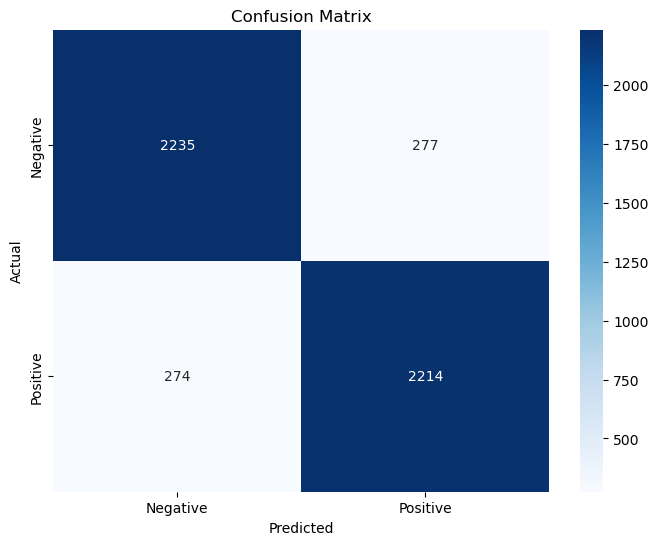

In [19]:
predictions = model.predict([test_inputs, test_masks])[0].argmax(axis=-1)
accuracy = accuracy_score(test_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions, average='binary')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# plot the confusion matrix 
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g',cmap='Blues',
           xticklabels=['Negative','Positive'],
           yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predictions

In [20]:
# sample movie reviews for sentiment prediction.
sample_reviews = ["The movie was fantastic!", "It was a waste of time."]
sample_tokens = [tokenizer.encode(i, add_special_tokens=True, max_length=max_len) 
                 for i in sample_reviews]
sample_tokens_padded = np.array([i + [0]*(max_len-len(i)) for i in sample_tokens])
sample_masks = np.where(sample_tokens_padded != 0, 1, 0)
sample_predictions = model.predict([sample_tokens_padded, sample_masks])[0].argmax(axis=-1)
# Print the original review and its predicted sentiment.
for review, sentiment in zip(sample_reviews, sample_predictions):
    print(f"Review: {review} | Sentiment: {'Positive' if sentiment == 1 else 'Negative'}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 42ms/step
Review: The movie was fantastic! | Sentiment: Positive
Review: It was a waste of time. | Sentiment: Negative
